# Classificação de imagens sobre o CIFAR10

Nesta parte, vamos treinar uma rede neural convolucional para aprender a classificar imagens. Vamos usar o conjunto de dados [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), que contém 60000 imagens, cada uma das quais pertence a uma de dez classes. A figura abaixo apresenta algumas imagens desse conjunto de dados para cada uma das dez classes existentes.

<center><img src='https://miro.medium.com/max/700/1*6XQqOifwnmplS22zCRRVaw.png'></center>

Vamos começar importando os pacotes necessários.

In [3]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

Vamos agora fazer o download do conjunto de dados.

In [4]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135M/135M [00:11<00:00, 11.7MB/s] 


O conjunto de dados vem em um formato bastante conhecido em sistemas Unix, o tgz. O trecho de código a seguir extrai os dados deste arquivo.

In [5]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

O conjunto de dados é extraído para o diretório `.data/cifar10`. Os exemplos estão contidos em duas pastas, `train` e` test`, que correspondem ao conjunto de treinamento (50.000 imagens) e ao conjunto de teste (10.000 imagens), respectivamente. Cada uma dessas pastas por sua vez contém 10 subpastas, uma para cada classe de imagens. Vamos verificar isso usando `os.listdir`.

In [6]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['truck', 'automobile', 'deer', 'dog', 'horse', 'frog', 'ship', 'cat', 'airplane', 'bird']


A estrutura de diretórios descritaacima (uma pasta por classe) é usada para organizar muitos conjuntos de dados na área de Visão Computacional, e a maioria das bibliotecas de aprendizado profundo fornecem utilitários para trabalhar com tais conjuntos de dados. No PyTorch, podemos usar a classe `ImageFolder` do pacote `torchvision` para carregar os dados como tensores.

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Vamos examinar o primeiro exemplo do conjunto de treinamento.

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

A lista de classes é armazenada na propriedade `.classes` do conjunto de dados. O rótulo numérico de cada elemento corresponde ao índice do rótulo do elemento na lista de classes.

In [9]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Podemo visualizar a imagem do exemplo correspondente ao índice.

Outro exemplo:

## Preparação dos conjuntos de dados

In [12]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

Com o uso de uma função utilitária, podemos visualizar o conjunto de imagens contido em um lote como um mosaico.

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/home/ebezerra/anaconda3/envs/ailab311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


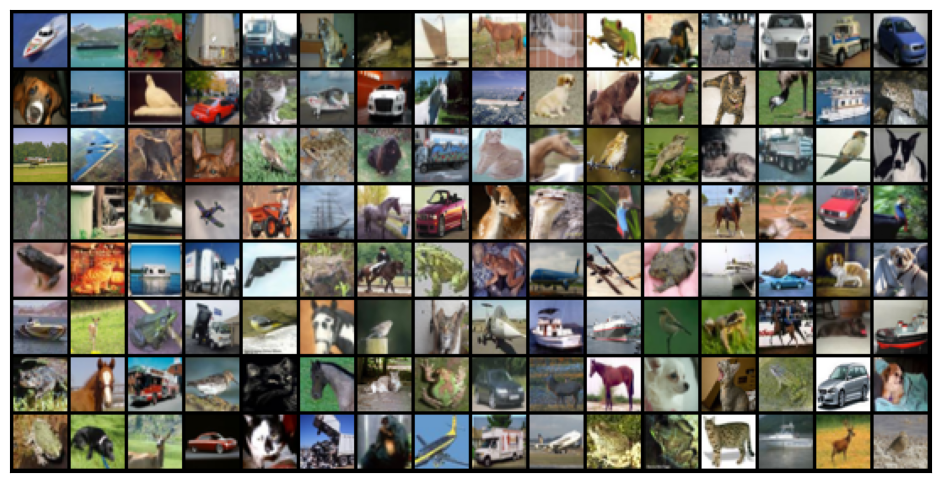

In [15]:
show_batch(train_dl)

## Definição do modelo

In [16]:
import torch.nn as nn
import torch.nn.functional as F

simple_model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [17]:
# Define the CNN Model
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [18]:
model = CIFAR10_CNN()
model

CIFAR10_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dr

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.6256,  0.3351,  0.4952,  0.6764, -0.3415, -0.6643, -0.0166, -0.3604,
         0.1976,  0.0570], grad_fn=<SelectBackward0>)


## Treinamento

100%|██████████| 170M/170M [00:15<00:00, 11.1MB/s]   


Epoch 1/10 - Train Loss: 1.3335 - Val Loss: 1.0243
Epoch 2/10 - Train Loss: 0.9919 - Val Loss: 0.9028
Epoch 3/10 - Train Loss: 0.8614 - Val Loss: 0.7886
Epoch 4/10 - Train Loss: 0.7930 - Val Loss: 0.7413
Epoch 5/10 - Train Loss: 0.7351 - Val Loss: 0.6988
Epoch 6/10 - Train Loss: 0.6934 - Val Loss: 0.7238
Epoch 7/10 - Train Loss: 0.6582 - Val Loss: 0.6761
Epoch 8/10 - Train Loss: 0.6331 - Val Loss: 0.6521
Epoch 9/10 - Train Loss: 0.6049 - Val Loss: 0.6491
Epoch 10/10 - Train Loss: 0.5829 - Val Loss: 0.6201


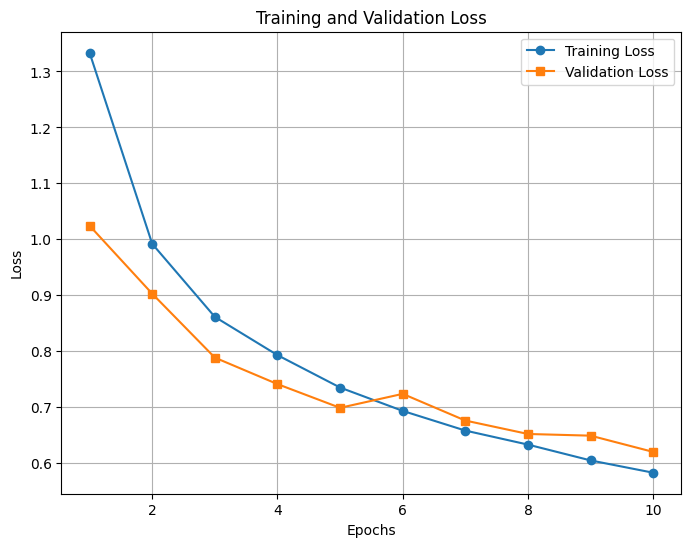

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss tracking
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

## Avaliação no conjunto de teste

A seguir, calculamos a matriz de confusão e exibimos algumas inferências de exemplo no conjunto de teste.


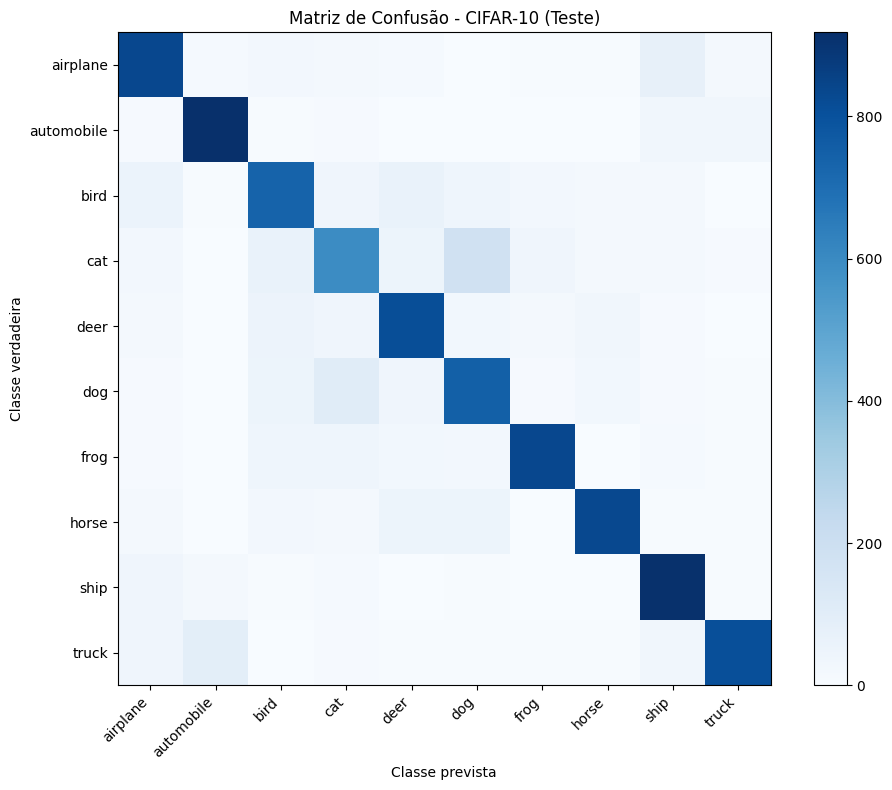

Acurácia no teste: 0.8033


In [21]:
# Usamos uma transformação sem augmentation para avaliação e visualização
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset_eval = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=eval_transform)
testloader_eval = DataLoader(testset_eval, batch_size=batch_size, shuffle=False)
class_names = testset_eval.classes

model.eval()
conf_mat = torch.zeros(len(class_names), len(class_names), dtype=torch.int64)

with torch.no_grad():
    for images, labels in testloader_eval:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for t, p in zip(labels.view(-1), preds.view(-1)):
            conf_mat[t.long(), p.long()] += 1

plt.figure(figsize=(10, 8))
plt.imshow(conf_mat.cpu().numpy(), cmap='Blues')
plt.title('Matriz de Confusão - CIFAR-10 (Teste)')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

acc_test = conf_mat.diag().sum().float() / conf_mat.sum().float()
print(f'Acurácia no teste: {acc_test.item():.4f}')


#### Matriz de confusão normalizada (por classe verdadeira)


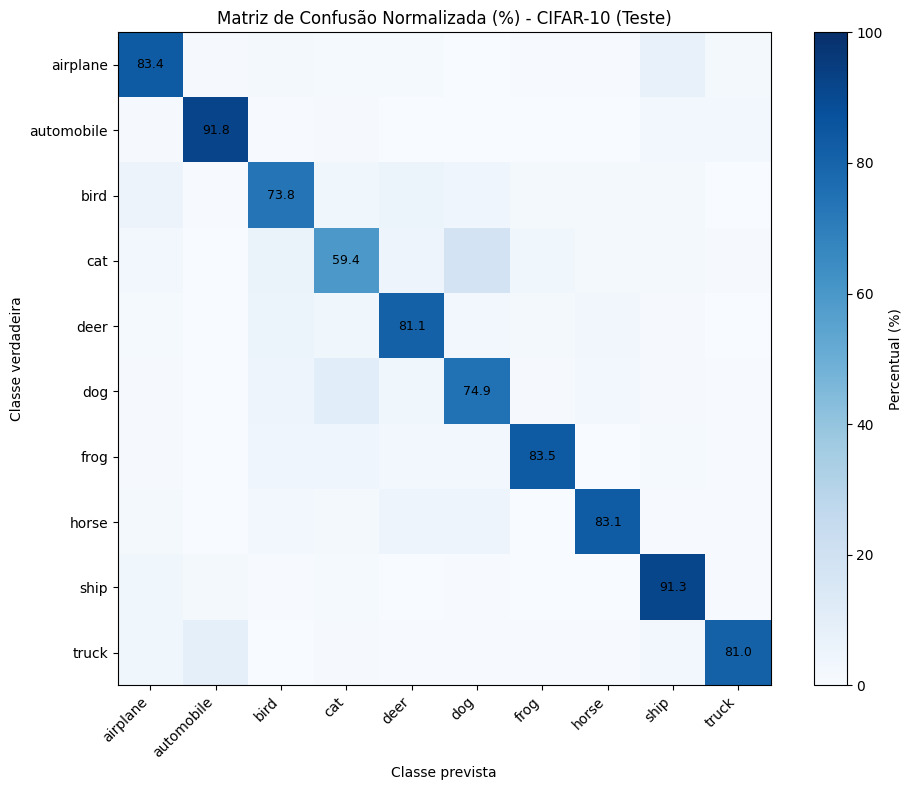

In [22]:
# Normalização por linha (classe verdadeira) em porcentagem
conf_mat_float = conf_mat.float()
row_sums = conf_mat_float.sum(dim=1, keepdim=True).clamp_min(1.0)
conf_mat_norm = (conf_mat_float / row_sums) * 100.0

plt.figure(figsize=(10, 8))
plt.imshow(conf_mat_norm.cpu().numpy(), cmap='Blues', vmin=0, vmax=100)
plt.title('Matriz de Confusão Normalizada (%) - CIFAR-10 (Teste)')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)
cbar = plt.colorbar()
cbar.set_label('Percentual (%)')

# Anota os valores na diagonal para leitura rápida
for i in range(len(class_names)):
    plt.text(i, i, f"{conf_mat_norm[i, i].item():.1f}", ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()


### Inferências de exemplo

Este bloco realiza uma inspeção qualitativa das predições do modelo no conjunto de teste. Primeiro, a função `denormalize` desfaz a normalização aplicada às imagens (`mean=0.5`, `std=0.5`), permitindo visualizar os pixels em uma escala mais natural. Em seguida, o modelo é colocado em modo de avaliação (`model.eval()`), um lote de imagens e rótulos é obtido de `testloader_eval`, e as imagens são enviadas para o dispositivo de execução (CPU/GPU). Com `torch.no_grad()`, o código executa a inferência sem calcular gradientes (mais eficiente para teste), extrai a classe prevista com `argmax`, e traz os resultados para CPU. Por fim, exibe 8 exemplos em uma grade 2x4, mostrando cada imagem com o rótulo verdadeiro (`True`) e o rótulo previsto (`Pred`), o que ajuda a interpretar visualmente os acertos e erros do modelo.

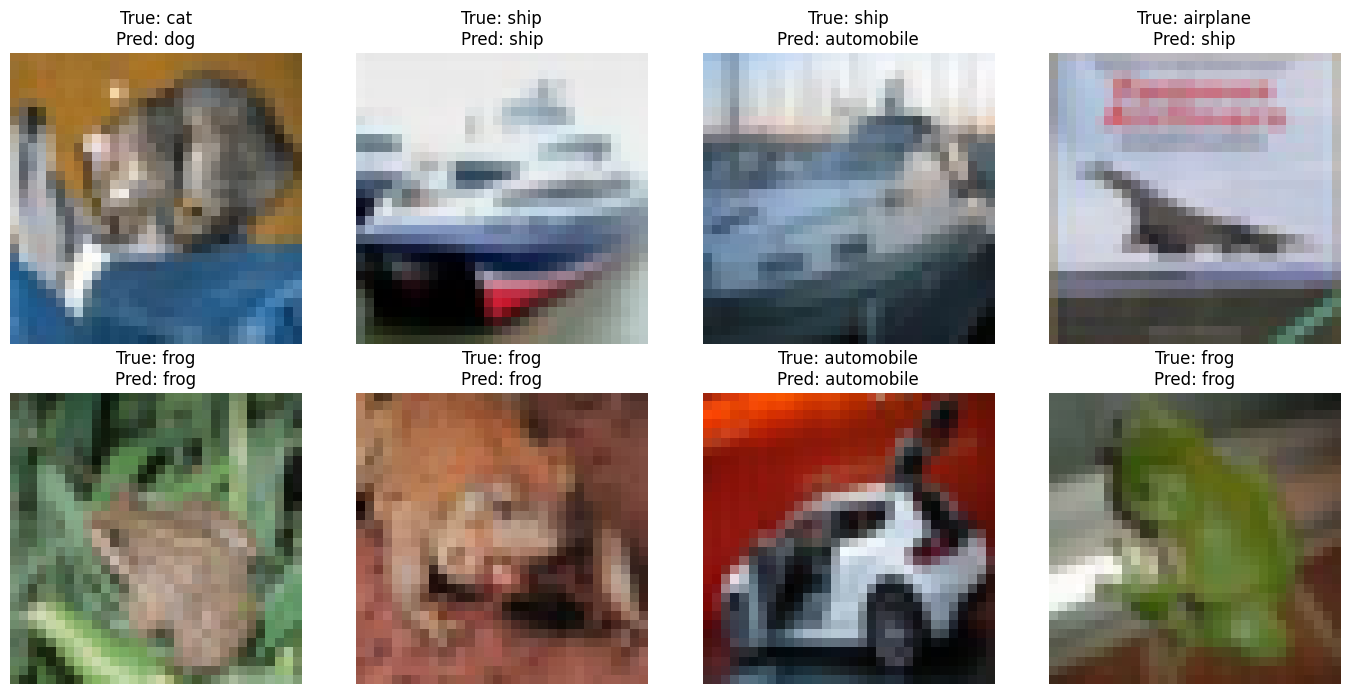

In [23]:
def denormalize(img):
    # Inverte normalize(mean=0.5, std=0.5): x = x*0.5 + 0.5
    return img * 0.5 + 0.5

model.eval()
images, labels = next(iter(testloader_eval))
images_device = images.to(device)

with torch.no_grad():
    outputs = model(images_device)
    preds = outputs.argmax(dim=1).cpu()

num_examples = 8
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for i in range(num_examples):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Referências

- Luis Serrano: [A friendly introduction to Convolutional Neural Networks and Image Recognition](https://youtu.be/2-Ol7ZB0MmU)

- Vincent Dumoulin, Francesco Visin: [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285) 
- Animações no [github](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)
- Irhum Shafkat: [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)
- Sylvian Gugger: [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) (apresenta detalhes de implementação de uma camada de convolução 2D)